# Maxp Regionalization

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append("../")

In [3]:
from spopt import MaxPHeuristic as MaxP
import geopandas as gpd
import libpysal
import numpy as np

##### Mexican State Regional Income Clustering

Cluster 32 Mexican states into the maximum number of regions such that each region as at least 5 states and homogeneity in per captia gross regional product over 1950-2000 is maximized.

<AxesSubplot:>

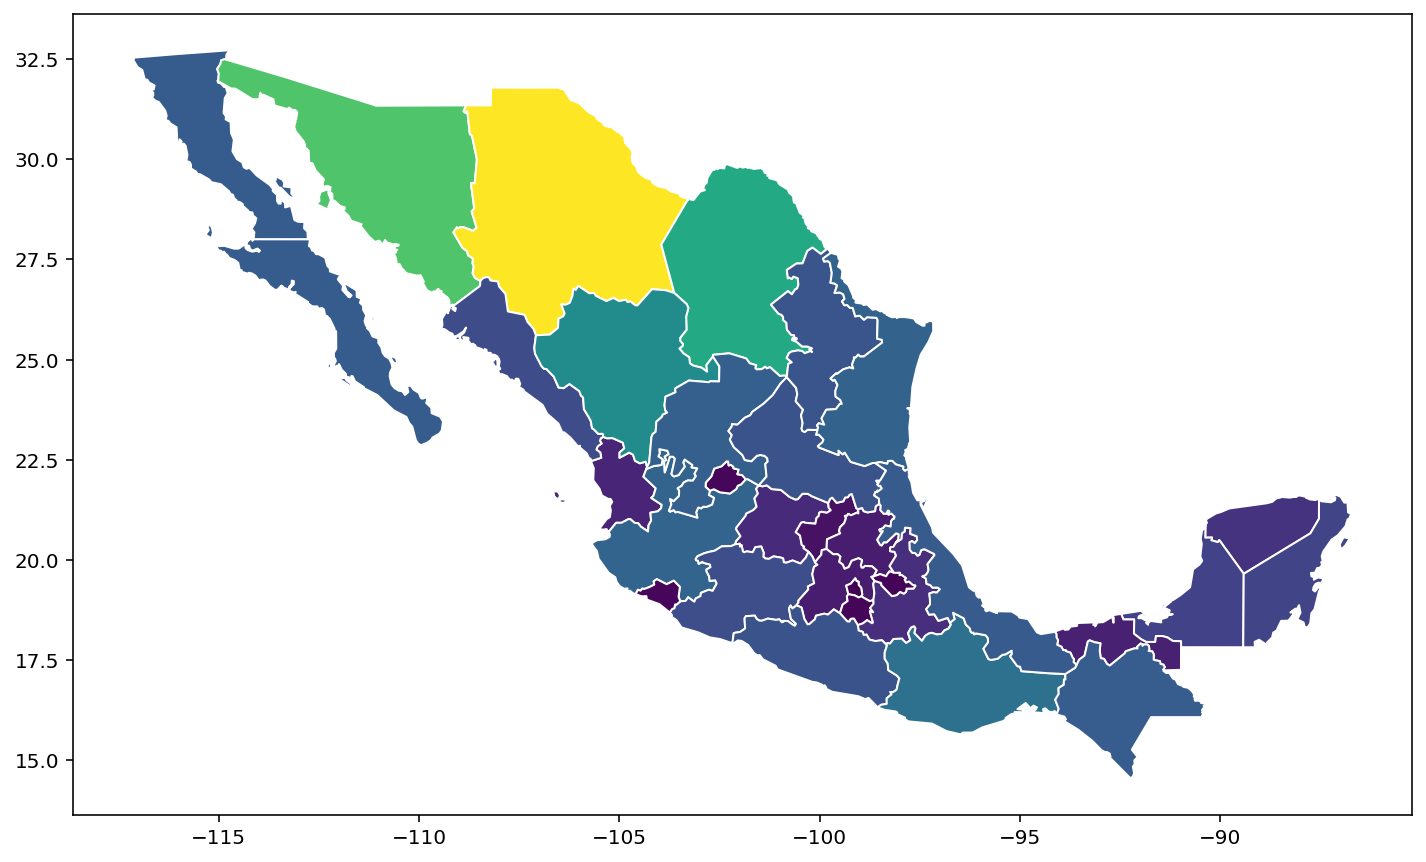

In [14]:
pth = libpysal.examples.get_path('mexicojoin.shp')
mexico = gpd.read_file(pth)
mexico.plot(column='AREA', figsize=(12,8), edgecolor='w')

In [5]:
attrs_name = [f'PCGDP{year}' for year in range(1950,2010, 10)]
attrs_name

['PCGDP1950', 'PCGDP1960', 'PCGDP1970', 'PCGDP1980', 'PCGDP1990', 'PCGDP2000']

In [6]:
w = libpysal.weights.Queen.from_dataframe(mexico)
threshold = 5
top_n = 2
mexico['count'] = 1
threshold_name = 'count'

In [7]:
model = MaxP(mexico, w, attrs_name, threshold_name, threshold, top_n)
model.solve()
mexico['maxp_new'] = model.labels_

In [8]:
model.p

6

<AxesSubplot:>

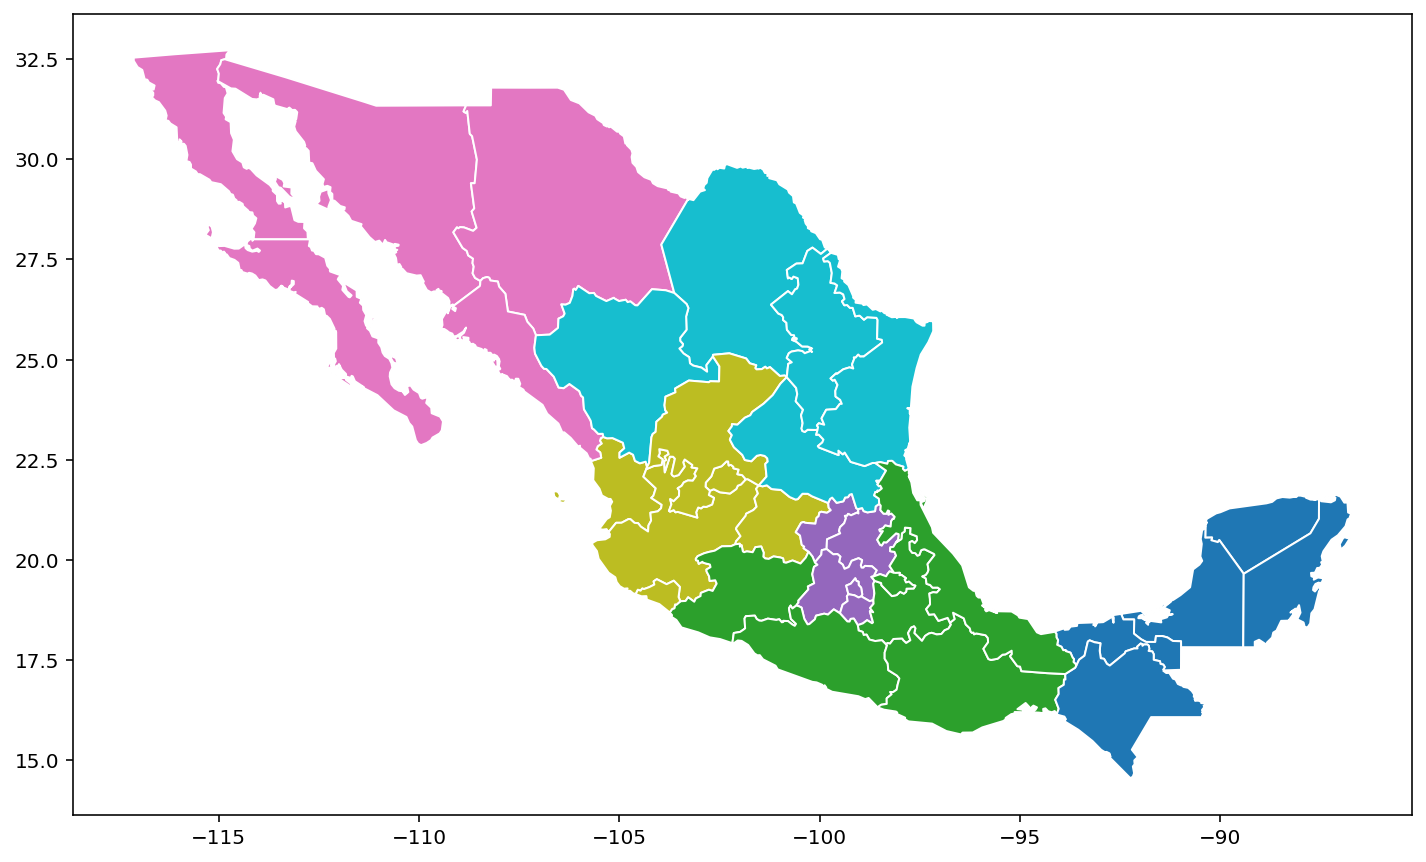

In [9]:
mexico.plot(column='maxp_new', categorical=True, figsize=(12,8), edgecolor='w')

## Change threshold to min of 3 states per region

In [10]:
np.random.seed(123456)
threshold=3
model = MaxP(mexico, w, attrs_name, threshold_name, threshold, top_n)
model.solve()

In [11]:
mexico['maxp_3'] = model.labels_
mexico.groupby(by='maxp_3').count()

,POLY_ID,AREA,CODE,NAME,PERIMETER,ACRES,HECTARES,PCGDP1940,PCGDP1950,PCGDP1960,...,LPCGDP50,LPCGDP60,LPCGDP70,LPCGDP80,LPCGDP90,LPCGDP00,TEST,geometry,count,maxp_new
maxp_3,,,,,,,,,,,,,,,,,,,,,
1,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
2,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
3,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
4,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
5,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
6,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
7,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
8,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
9,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


In [12]:
model.p

10

<AxesSubplot:>

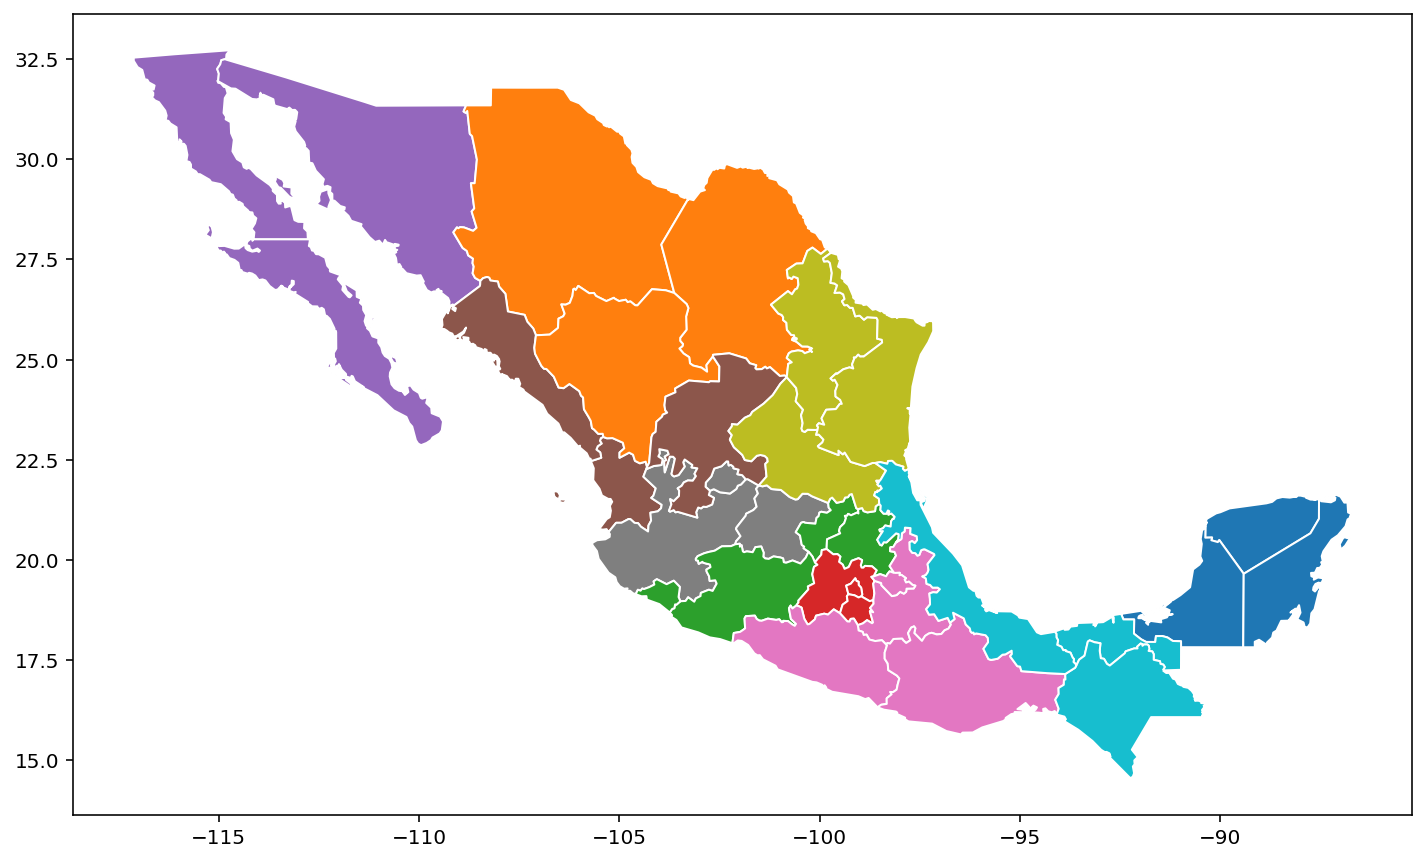

In [13]:
mexico.plot(column='maxp_3', categorical=True, figsize=(12,8), edgecolor='w')